In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
from sqlalchemy import desc # COMMENT

date_recent = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
print(date_recent)

('2017-08-23',)


In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(date_one_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= dt.date(2017,8,23)).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_db = pd.DataFrame(results)
precipitation_db.columns = ["Date", "Precipitation"]
precipitation_db["Date"] = pd.to_datetime(precipitation_db["Date"], format='%Y-%m-%d')

# Sort the dataframe by date
precipitation_db = precipitation_db.dropna()
precipitation_db.sort_values(by="Date", ascending = True, inplace = True) 
precipitation_db.reset_index(drop=True)
precipitation_db.set_index("Date", inplace=True)

precipitation_db

2016-08-23


,Precipitation
Date,
2016-08-23,0.0
2016-08-23,0.5
2016-08-23,1.3
2016-08-23,17.8
2016-08-23,3.8
...,...
2017-08-22,12.7
2017-08-23,0.0
2017-08-23,2.0


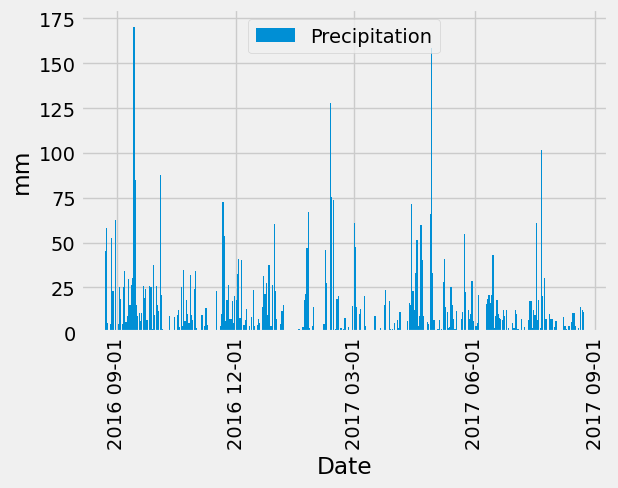

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker 

# Create figure and plot space
fig, ax = plt.subplots()

ax.bar(precipitation_db.index.values, precipitation_db["Precipitation"], label="Precipitation", width = 0.9)
ax.set(xlabel="Date", ylabel="mm")

plt.xticks(rotation=90)
plt.legend(loc="upper center")

y_min = precipitation_db["Precipitation"].min()
y_max = precipitation_db["Precipitation"].max()
plt.ylim((y_min,y_max+10))

plt.tight_layout()

date_form = DateFormatter("%Y %m-%d")
ax.xaxis.set_major_formatter(date_form)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=12))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = pd.DataFrame(precipitation_db["Precipitation"].describe())
precipitation_summary

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(func.distinct(Measurement.station))).all()
print(stations)

[(9,)]


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
counts = [Measurement.station, 
       func.count(Measurement.station)] 
station_counts = session.query(*counts).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [func.min(Measurement.tobs),
          func.max(Measurement.tobs),
          func.avg(Measurement.tobs)]
station_temps = session.query(*temps).\
    filter(Measurement.station == "USC00519281").all()
station_temps

[(12.2, 29.4, 22.03582251082252)]

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and...
temp_results = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date <= dt.date(2017,8,23)).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()
# temp_results

temperature_db = pd.DataFrame(temp_results)
temperature_db.columns = ["Temperature"]
temperature_db


,Temperature
0,25.0
1,25.0
2,26.7
3,26.7
4,23.9
...,...
347,25.0
348,25.0
349,24.4
350,24.4


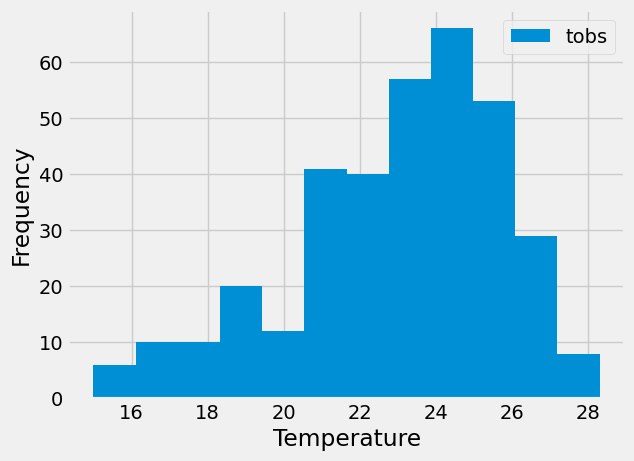

In [20]:
# Plot the results as a histogram
figure2 = plt.hist(temperature_db["Temperature"], bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()


# Close Session

In [21]:
# Close Session
session.close()